# General Behavior Analysis

This notebook analyzes general flight behavior from braidz tracking data, including:
- Trajectory analysis and filtering
- Saccade detection from angular velocity
- Spatial occupancy analysis
- Kinematic visualization

## Setup and Imports

In [235]:
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, find_peaks, peak_prominences, peak_widths
from tqdm import tqdm
from typing import List, Optional, Tuple
import seaborn as sns

## Configuration

Define analysis parameters and data sources.

In [227]:
# Analysis parameters
SAMPLING_RATE = 0.01  # seconds per frame (100 Hz)
MIN_LENGTH = 300  # minimum number of frames per trajectory (3 seconds)

# Data folder and files to analyze
DATA_FOLDER = "/mnt/data/experiments"
BRAIDZ_FILES = [
    "20260106_142948.braidz",
    "20251219_143603.braidz",
    "20260107_142225.braidz",
    "20260109_154652.braidz",
    "20260108_165038.braidz",
    "20260113_162930.braidz",
]

## Data Loading

Load tracking data from braidz files.

In [ ]:
def load_braidz_file(filepath: Path) -> tuple[pd.DataFrame | None, pd.DataFrame | None]:
    """Load kalman estimates and opto data from a braidz file.

    Args:
        filepath: Path to the .braidz file

    Returns:
        Tuple of (tracking_df, opto_df) or (None, None) if loading fails
    """
    try:
        with ZipFile(filepath, "r") as zip_ref:
            df = pd.read_csv(
                zip_ref.open("kalman_estimates.csv.gz"), compression="gzip", comment="#"
            )
            opto = pd.read_csv(zip_ref.open("opto.csv"))

        # Add file identifier to track data source
        df["file"] = filepath.name
        opto["file"] = filepath.name
        return df, opto

    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None


# Load all specified braidz files
dfs = []
optos = []

for file in tqdm(BRAIDZ_FILES, desc="Loading braidz files"):
    filepath = Path(DATA_FOLDER) / file

    if not filepath.is_file():
        print(f"File {filepath} does not exist. Skipping.")
        continue

    df, opto = load_braidz_file(filepath)
    if df is not None:
        dfs.append(df)
        optos.append(opto)

# Concatenate all data
df = pd.concat(dfs, ignore_index=True)
opto = pd.concat(optos, ignore_index=True)

print(f"Loaded {len(dfs)} files with {len(opto)} optogenetic trials")

Loading braidz files:   0%|          | 0/6 [00:00<?, ?it/s]

File /mnt/data/experiments/20260106_142948.braidz does not exist. Skipping.


Loading braidz files:  33%|███▎      | 2/6 [00:16<00:33,  8.43s/it]

## Trajectory Filtering

Filter trajectories based on length and spatial position to focus on valid flight behavior in the arena center.

In [ ]:
# Group by individual fly tracks (obj_id) within each file
grouped_df = df.groupby(["obj_id", "file"])

print(f"Number of initial groups: {len(grouped_df)}")

# Filter 1: Remove short trajectories (less than MIN_LENGTH frames)
filtered_groups = [group for _, group in grouped_df if len(group) >= MIN_LENGTH]
print(f"Number of groups after length filter: {len(filtered_groups)}")

# Filter 2: Keep only trajectories in the center of the arena
# X and Y median should be between -0.2 and 0.2 (center 400mm of 500mm diameter)
# Z median should be between 0.1 and 0.25 (flight height range)
filtered_groups = [
    group
    for group in filtered_groups
    if (-0.2 < group["x"].median() < 0.2)
    and (-0.2 < group["y"].median() < 0.2)
    and (0.1 < group["z"].median() < 0.25)
]
print(f"Number of groups after position filter: {len(filtered_groups)}")

# Sort groups by length (longest first)
filtered_groups.sort(key=len, reverse=True)

Number of initial groups: 107343
Number of groups after length filter: 4592
Number of groups after position filter: 416


# Analysis function

In [253]:
def smooth_df(
    df: pd.DataFrame,
    columns: list = ["x", "y", "z", "xvel", "yvel", "zvel"],
    window_length: int = 51,
    polyorder: int = 3,
) -> pd.DataFrame:
    """Apply Savitzky-Golay filter to smooth position and velocity data."""
    smoothed = df.copy()
    for col in columns:
        if col in df.columns:
            smoothed[f"{col}_smooth"] = savgol_filter(
                df[col], window_length=window_length, polyorder=polyorder
            )
    return smoothed


def calculate_velocities(
    df: pd.DataFrame,
    smooth_angular: bool = True,
    angular_window: int = 7,
    angular_polyorder: int = 2,
) -> pd.DataFrame:
    """Calculate linear and angular velocities from smoothed position data."""
    vel = df.copy()

    # Check for required columns
    required_cols = ["xvel_smooth", "yvel_smooth", "zvel_smooth"]
    if not all(col in vel.columns for col in required_cols):
        raise ValueError(
            f"DataFrame must contain smoothed velocity columns: {required_cols}"
        )

    # Linear velocity (3D speed)
    vel["linear_velocity"] = np.sqrt(
        vel["xvel_smooth"] ** 2 + vel["yvel_smooth"] ** 2 + vel["zvel_smooth"] ** 2
    )

    # Angular velocity (heading change rate)
    vel["theta"] = np.arctan2(vel["yvel_smooth"], vel["xvel_smooth"])
    vel["theta_unwrap"] = np.unwrap(vel["theta"])
    vel["angular_velocity_raw"] = np.gradient(vel["theta_unwrap"], SAMPLING_RATE)

    # Smooth angular velocity and convert to degrees
    if smooth_angular:
        vel["angular_velocity"] = np.rad2deg(
            savgol_filter(
                vel["angular_velocity_raw"],
                window_length=angular_window,
                polyorder=angular_polyorder,
            )
        )
    else:
        vel["angular_velocity"] = np.rad2deg(vel["angular_velocity_raw"])

    return vel


def calculate_accelerations(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate linear and angular accelerations."""
    acc = df.copy()

    if "linear_velocity" not in acc.columns:
        raise ValueError("DataFrame must contain 'linear_velocity' column.")
    if "angular_velocity" not in acc.columns:
        raise ValueError("DataFrame must contain 'angular_velocity' column.")

    # Calculate accelerations and smooth them
    acc["linear_acceleration"] = savgol_filter(
        np.gradient(acc["linear_velocity"]), window_length=7, polyorder=2
    )

    acc["angular_acceleration"] = savgol_filter(
        np.gradient(acc["angular_velocity"]), window_length=7, polyorder=2
    )

    return acc


def calculate_kinematic_features(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate derived kinematic features for behavioral analysis."""
    features = df.copy()

    # Turning radius (m) - instantaneous radius of curvature
    features["turning_radius"] = features["linear_velocity"] / (
        np.abs(np.deg2rad(features["angular_velocity"])) + 1e-10
    )

    # Agility metric - combined turning and speed
    features["agility"] = (
        np.abs(features["angular_velocity"]) * features["linear_velocity"]
    )

    # Acceleration-to-velocity ratios (kinematic signatures)
    features["angular_accel_ratio"] = features["angular_acceleration"] / (
        np.abs(features["angular_velocity"]) + 1e-10
    )
    features["linear_accel_ratio"] = features["linear_acceleration"] / (
        features["linear_velocity"] + 1e-10
    )

    # Centripetal acceleration (for turning maneuvers)
    features["centripetal_acceleration"] = (features["linear_velocity"] ** 2) / (
        features["turning_radius"] + 1e-10
    )

    # Speed change rate (how rapidly speed changes)
    features["speed_change_rate"] = np.abs(features["linear_acceleration"])

    # Turn rate (absolute angular velocity for unsigned analysis)
    features["turn_rate"] = np.abs(features["angular_velocity"])

    return features


from scipy.signal import peak_widths, peak_prominences


def detect_saccades(
    df: pd.DataFrame,
    angular_threshold: float = 500,  # deg/s
    distance: int = 20,  # frames
    max_linear_velocity: float = 0.3,
) -> pd.DataFrame:  # m/s
    """
    Detect saccades based on angular velocity peaks with linear velocity filtering.

    Saccades are rapid turns typically occurring at low forward speeds.
    """
    saccade_df = df.copy()

    # Check for required columns
    if "angular_velocity" not in saccade_df.columns:
        raise ValueError("DataFrame must contain 'angular_velocity' column.")
    if "linear_velocity" not in saccade_df.columns:
        raise ValueError("DataFrame must contain 'linear_velocity' column.")

    # Find peaks in angular velocity
    abs_ang_vel = np.abs(saccade_df["angular_velocity"].values)
    peaks, properties = find_peaks(
        abs_ang_vel,
        height=angular_threshold,
        distance=distance,
    )

    # Get peak properties
    prominences = peak_prominences(abs_ang_vel, peaks)[0]
    widths, width_heights, left_ips, right_ips = peak_widths(
        abs_ang_vel, peaks, rel_height=0.5
    )

    # Filter by linear velocity (saccades typically occur at lower speeds)
    valid_peaks = [
        i
        for i, p in enumerate(peaks)
        if saccade_df.iloc[p]["linear_velocity"] < max_linear_velocity
    ]

    # Mark saccade frames
    saccade_df["saccade"] = 0
    saccade_df["saccade_id"] = -1  # ID for each saccade event

    if len(valid_peaks) > 0:
        valid_peak_indices = peaks[valid_peaks]
        saccade_df.iloc[valid_peak_indices, saccade_df.columns.get_loc("saccade")] = 1

        # Assign unique ID to each saccade
        for saccade_id, peak_idx in enumerate(valid_peak_indices):
            saccade_df.iloc[peak_idx, saccade_df.columns.get_loc("saccade_id")] = (
                saccade_id
            )

        # Store peak properties
        saccade_df["prominence"] = 0.0
        saccade_df["width_frames"] = 0.0

        saccade_df.iloc[
            valid_peak_indices, saccade_df.columns.get_loc("prominence")
        ] = prominences[valid_peaks]
        saccade_df.iloc[
            valid_peak_indices, saccade_df.columns.get_loc("width_frames")
        ] = widths[valid_peaks]

    return saccade_df


def extract_saccade_features(df: pd.DataFrame, 
                            window_pre: int = 20,  # frames before peak
                            window_post: int = 20,  # frames after peak
                            baseline_frames: int = 10) -> pd.DataFrame:  # frames for baseline heading
    """
    Extract rich temporal and shape features for each detected saccade.
    
    Returns a DataFrame with one row per saccade, containing features for clustering.
    """
    saccade_peaks = df[df['saccade'] == 1]
    
    if len(saccade_peaks) == 0:
        return pd.DataFrame()
    
    # Get bout boundaries for all saccades
    abs_ang_vel = np.abs(df["angular_velocity"].values)
    peaks = df[df['saccade'] == 1].index.tolist()
    peak_indices = [df.index.get_loc(p) for p in peaks]
    
    # Calculate widths to find saccade start/end
    widths, width_heights, left_ips, right_ips = peak_widths(
        abs_ang_vel, peak_indices, rel_height=0.5
    )
    
    features_list = []
    
    for i, (idx, peak_row) in enumerate(saccade_peaks.iterrows()):
        # Define temporal window around peak
        peak_idx = df.index.get_loc(idx)
        
        # Bout boundaries from peak width analysis
        bout_start = int(np.floor(left_ips[i]))
        bout_end = int(np.ceil(right_ips[i]))
        
        # Ensure boundaries are valid
        bout_start = max(0, bout_start)
        bout_end = min(len(df), bout_end)
        
        # Define baseline windows (K frames before/after bout)
        pre_baseline_start = max(0, bout_start - baseline_frames)
        pre_baseline_end = bout_start
        
        post_baseline_start = bout_end
        post_baseline_end = min(len(df), bout_end + baseline_frames)
        
        # Skip if we don't have enough baseline frames
        if (pre_baseline_end - pre_baseline_start < baseline_frames // 2 or 
            post_baseline_end - post_baseline_start < baseline_frames // 2):
            continue
        
        # Extract bout and baseline windows
        bout = df.iloc[bout_start:bout_end]
        pre_baseline = df.iloc[pre_baseline_start:pre_baseline_end]
        post_baseline = df.iloc[post_baseline_start:post_baseline_end]
        
        # Skip if bout is too short
        if len(bout) < 5:
            continue

        # === HEADING CHANGE (Vector-based) ===
        # Define frame indices for vector calculation
        pre_frame = max(0, peak_idx - baseline_frames)
        peak_frame = peak_idx
        post_frame = min(len(df) - 1, peak_idx + baseline_frames)
        
        # Check we have valid x, y positions
        if 'x' in df.columns and 'y' in df.columns:
            # Get positions
            pos_pre = np.array([df.iloc[pre_frame]['x'], df.iloc[pre_frame]['y']])
            pos_peak = np.array([df.iloc[peak_frame]['x'], df.iloc[peak_frame]['y']])
            pos_post = np.array([df.iloc[post_frame]['x'], df.iloc[post_frame]['y']])
            
            # Calculate vectors
            vec_before = pos_peak - pos_pre  # Vector approaching saccade
            vec_after = pos_post - pos_peak   # Vector leaving saccade
            
            # Calculate signed angle between vectors
            # Using atan2 of cross and dot products
            dot = np.dot(vec_before, vec_after)
            cross = vec_before[0] * vec_after[1] - vec_before[1] * vec_after[0]
            heading_change = np.rad2deg(np.arctan2(cross, dot))
            
        elif 'xvel_smooth' in df.columns and 'yvel_smooth' in df.columns:
            # Alternative: use velocity vectors directly
            vel_before = np.array([
                df.iloc[pre_frame]['xvel_smooth'], 
                df.iloc[pre_frame]['yvel_smooth']
            ])
            vel_after = np.array([
                df.iloc[post_frame]['xvel_smooth'], 
                df.iloc[post_frame]['yvel_smooth']
            ])
            
            dot = np.dot(vel_before, vel_after)
            cross = vel_before[0] * vel_after[1] - vel_before[1] * vel_after[0]
            heading_change = np.rad2deg(np.arctan2(cross, dot))
            
        else:
            # Fallback
            heading_change = np.nan
        
        # === PEAK PROPERTIES ===
        peak_ang_vel = peak_row['angular_velocity']
        peak_abs_ang_vel = np.abs(peak_ang_vel)
        peak_linear_vel = peak_row['linear_velocity']
        prominence = peak_row.get('prominence', 0)
        width = widths[i]
        
        # === TEMPORAL FEATURES ===
        # Duration above threshold (50% of peak height)
        threshold_50 = peak_abs_ang_vel * 0.5
        above_threshold = np.abs(bout['angular_velocity']) > threshold_50
        duration = above_threshold.sum() * SAMPLING_RATE  # seconds
        
        # Rise time vs fall time (from bout start to peak, peak to bout end)
        frames_to_peak = peak_idx - bout_start
        frames_from_peak = bout_end - peak_idx
        rise_time = frames_to_peak * SAMPLING_RATE
        fall_time = frames_from_peak * SAMPLING_RATE
        
        # === SHAPE FEATURES ===
        ang_vel_profile = bout['angular_velocity'].values
        
        # Symmetry (skewness around peak)
        from scipy.stats import skew, kurtosis
        profile_skewness = skew(np.abs(ang_vel_profile))
        profile_kurtosis = kurtosis(np.abs(ang_vel_profile))
        
        # Sharpness: ratio of peak to mean
        sharpness = peak_abs_ang_vel / (np.abs(ang_vel_profile).mean() + 1e-10)
        
        # === KINEMATIC FEATURES ===
        # Peak acceleration
        peak_ang_accel = np.abs(bout['angular_acceleration']).max()
        
        # Acceleration asymmetry (does it accelerate faster than it decelerates?)
        pre_bout = bout.iloc[:frames_to_peak]
        post_bout = bout.iloc[frames_to_peak:]
        
        if len(pre_bout) > 0 and len(post_bout) > 0:
            pre_accel = pre_bout['angular_acceleration'].abs().max()
            post_accel = post_bout['angular_acceleration'].abs().max()
            accel_asymmetry = (pre_accel - post_accel) / (pre_accel + post_accel + 1e-10)
        else:
            accel_asymmetry = 0
        
        # === CONTEXT FEATURES ===
        # Linear velocity before, during, after
        pre_linear_vel = pre_baseline['linear_velocity'].mean()
        post_linear_vel = post_baseline['linear_velocity'].mean()
        during_linear_vel = bout['linear_velocity'].mean()
        speed_change = post_linear_vel - pre_linear_vel
        
        # Was the fly accelerating or decelerating during turn?
        linear_accel_during = bout['linear_acceleration'].mean()
        
        # Turn direction
        turn_direction = np.sign(peak_ang_vel)  # -1 = left, +1 = right
        
        # === COMPILED FEATURES ===
        features = {
            'saccade_id': peak_row['saccade_id'],
            'peak_idx': idx,
            'bout_start': df.iloc[bout_start].name,
            'bout_end': df.iloc[bout_end].name,
            
            # Peak properties
            'peak_angular_velocity': peak_abs_ang_vel,
            'peak_linear_velocity': peak_linear_vel,
            'prominence': prominence,
            'width_frames': width,
            'turn_direction': turn_direction,
            
            # Temporal
            'duration': duration,
            'rise_time': rise_time,
            'fall_time': fall_time,
            'rise_fall_ratio': rise_time / (fall_time + 1e-10),
            
            # Shape
            'skewness': profile_skewness,
            'kurtosis': profile_kurtosis,
            'sharpness': sharpness,
            
            # Kinematics
            'heading_change': heading_change,  # The functional outcome!
            'peak_angular_acceleration': peak_ang_accel,
            'accel_asymmetry': accel_asymmetry,
            
            # Context
            'pre_linear_velocity': pre_linear_vel,
            'during_linear_velocity': during_linear_vel,
            'post_linear_velocity': post_linear_vel,
            'speed_change': speed_change,
            'linear_accel_during_turn': linear_accel_during,
            
            # Derived metrics
            'turning_agility': peak_abs_ang_vel * during_linear_vel,
        }
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)


def run_pipeline(
    df: pd.DataFrame,
    smooth_window: int = 51,
    smooth_polyorder: int = 3,
    angular_smooth_window: int = 7,
    angular_smooth_polyorder: int = 2,
    saccade_threshold: float = 500,
    saccade_distance: int = 20,
    saccade_max_speed: float = 0.3,
) -> pd.DataFrame:
    """
    Run the complete kinematic analysis pipeline.

    Parameters:
    -----------
    df : pd.DataFrame
        Input trajectory data with x, y, z, xvel, yvel, zvel columns
    smooth_window : int
        Window length for Savitzky-Golay smoothing of positions
    smooth_polyorder : int
        Polynomial order for position smoothing
    angular_smooth_window : int
        Window length for angular velocity smoothing
    angular_smooth_polyorder : int
        Polynomial order for angular velocity smoothing
    saccade_threshold : float
        Angular velocity threshold for saccade detection (deg/s)
    saccade_distance : int
        Minimum distance between saccade peaks (frames)
    saccade_max_speed : float
        Maximum linear velocity for valid saccades (m/s)

    Returns:
    --------
    pd.DataFrame
        Processed trajectory with all kinematic features
    """
    # Step 1: Smooth raw data
    df_smoothed = smooth_df(df, window_length=smooth_window, polyorder=smooth_polyorder)

    # Step 2: Calculate velocities
    df_velocity = calculate_velocities(
        df_smoothed,
        angular_window=angular_smooth_window,
        angular_polyorder=angular_smooth_polyorder,
    )

    # Step 3: Calculate accelerations
    df_acceleration = calculate_accelerations(df_velocity)

    # Step 4: Calculate derived kinematic features
    df_kinematics = calculate_kinematic_features(df_acceleration)

    # Step 5: Detect saccades
    df_final = detect_saccades(
        df_kinematics,
        angular_threshold=saccade_threshold,
        distance=saccade_distance,
        max_linear_velocity=saccade_max_speed,
    )

    return df_final


# Plotting functions

In [254]:
def plot_xy(df: pd.DataFrame, ax: plt.axes = None) -> Optional[plt.axes]:
    """
    Plot the xy position of the fly trajectory. Use and return the ax object if provided; otherwise, initialize a new figure.
    """

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

    ax.plot(df["x"], df["y"])
    ax.set_xlabel("X Position (m)")
    ax.set_ylabel("Y Position (m)")
    ax.set_title("Fly Trajectory in XY Plane")
    ax.set_aspect("equal", "box")

    return ax


def plot_velocity(
    df: pd.DataFrame, column: str = "linear_velocity", ax: plt.axes = None
) -> Optional[plt.axes]:
    """
    Plot the specified velocity component over time. Use and return the ax object if provided; otherwise, initialize a new figure.
    """

    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

    ax.plot(df.index * SAMPLING_RATE, df[column])
    ax.set_xlabel("Time (s)")

    if column == "linear_velocity":
        ax.set_ylabel("Linear Velocity (m/s)")
    else:
        ax.set_ylabel("Angular Velocity (rad/s)")

    # Add saccade markers
    if "saccade" in df.columns:
        saccade_times = df.index[df["saccade"] == 1] * SAMPLING_RATE
        saccade_values = df.loc[df["saccade"] == 1, column]
        ax.scatter(
            saccade_times, saccade_values, color="red", label="Saccades", zorder=5
        )

    return ax


def plot_kinematics(df: pd.DataFrame) -> None:
    """
    Plot the kinematic data including linear and angular velocity.
    """
    mosaic = [["xy", "xy", "lv", "lv", "lv"], ["xy", "xy", "av", "av", "av"]]

    fig, axs = plt.subplot_mosaic(mosaic, figsize=(15, 5))
    plot_xy(df, ax=axs["xy"])
    plot_velocity(df, column="linear_velocity", ax=axs["lv"])
    plot_velocity(df, column="angular_velocity", ax=axs["av"])
    plt.tight_layout()
    plt.show()

In [255]:
# Usage
processed_df = [run_pipeline(group) for group in tqdm(filtered_groups, desc="Processing trajectories")]
processed_data_df = pd.concat(processed_df, ignore_index=True)
saccade_features = extract_saccade_features(processed_data_df, window_pre=10, window_post=10)

Processing trajectories: 100%|██████████| 416/416 [00:06<00:00, 65.94it/s]


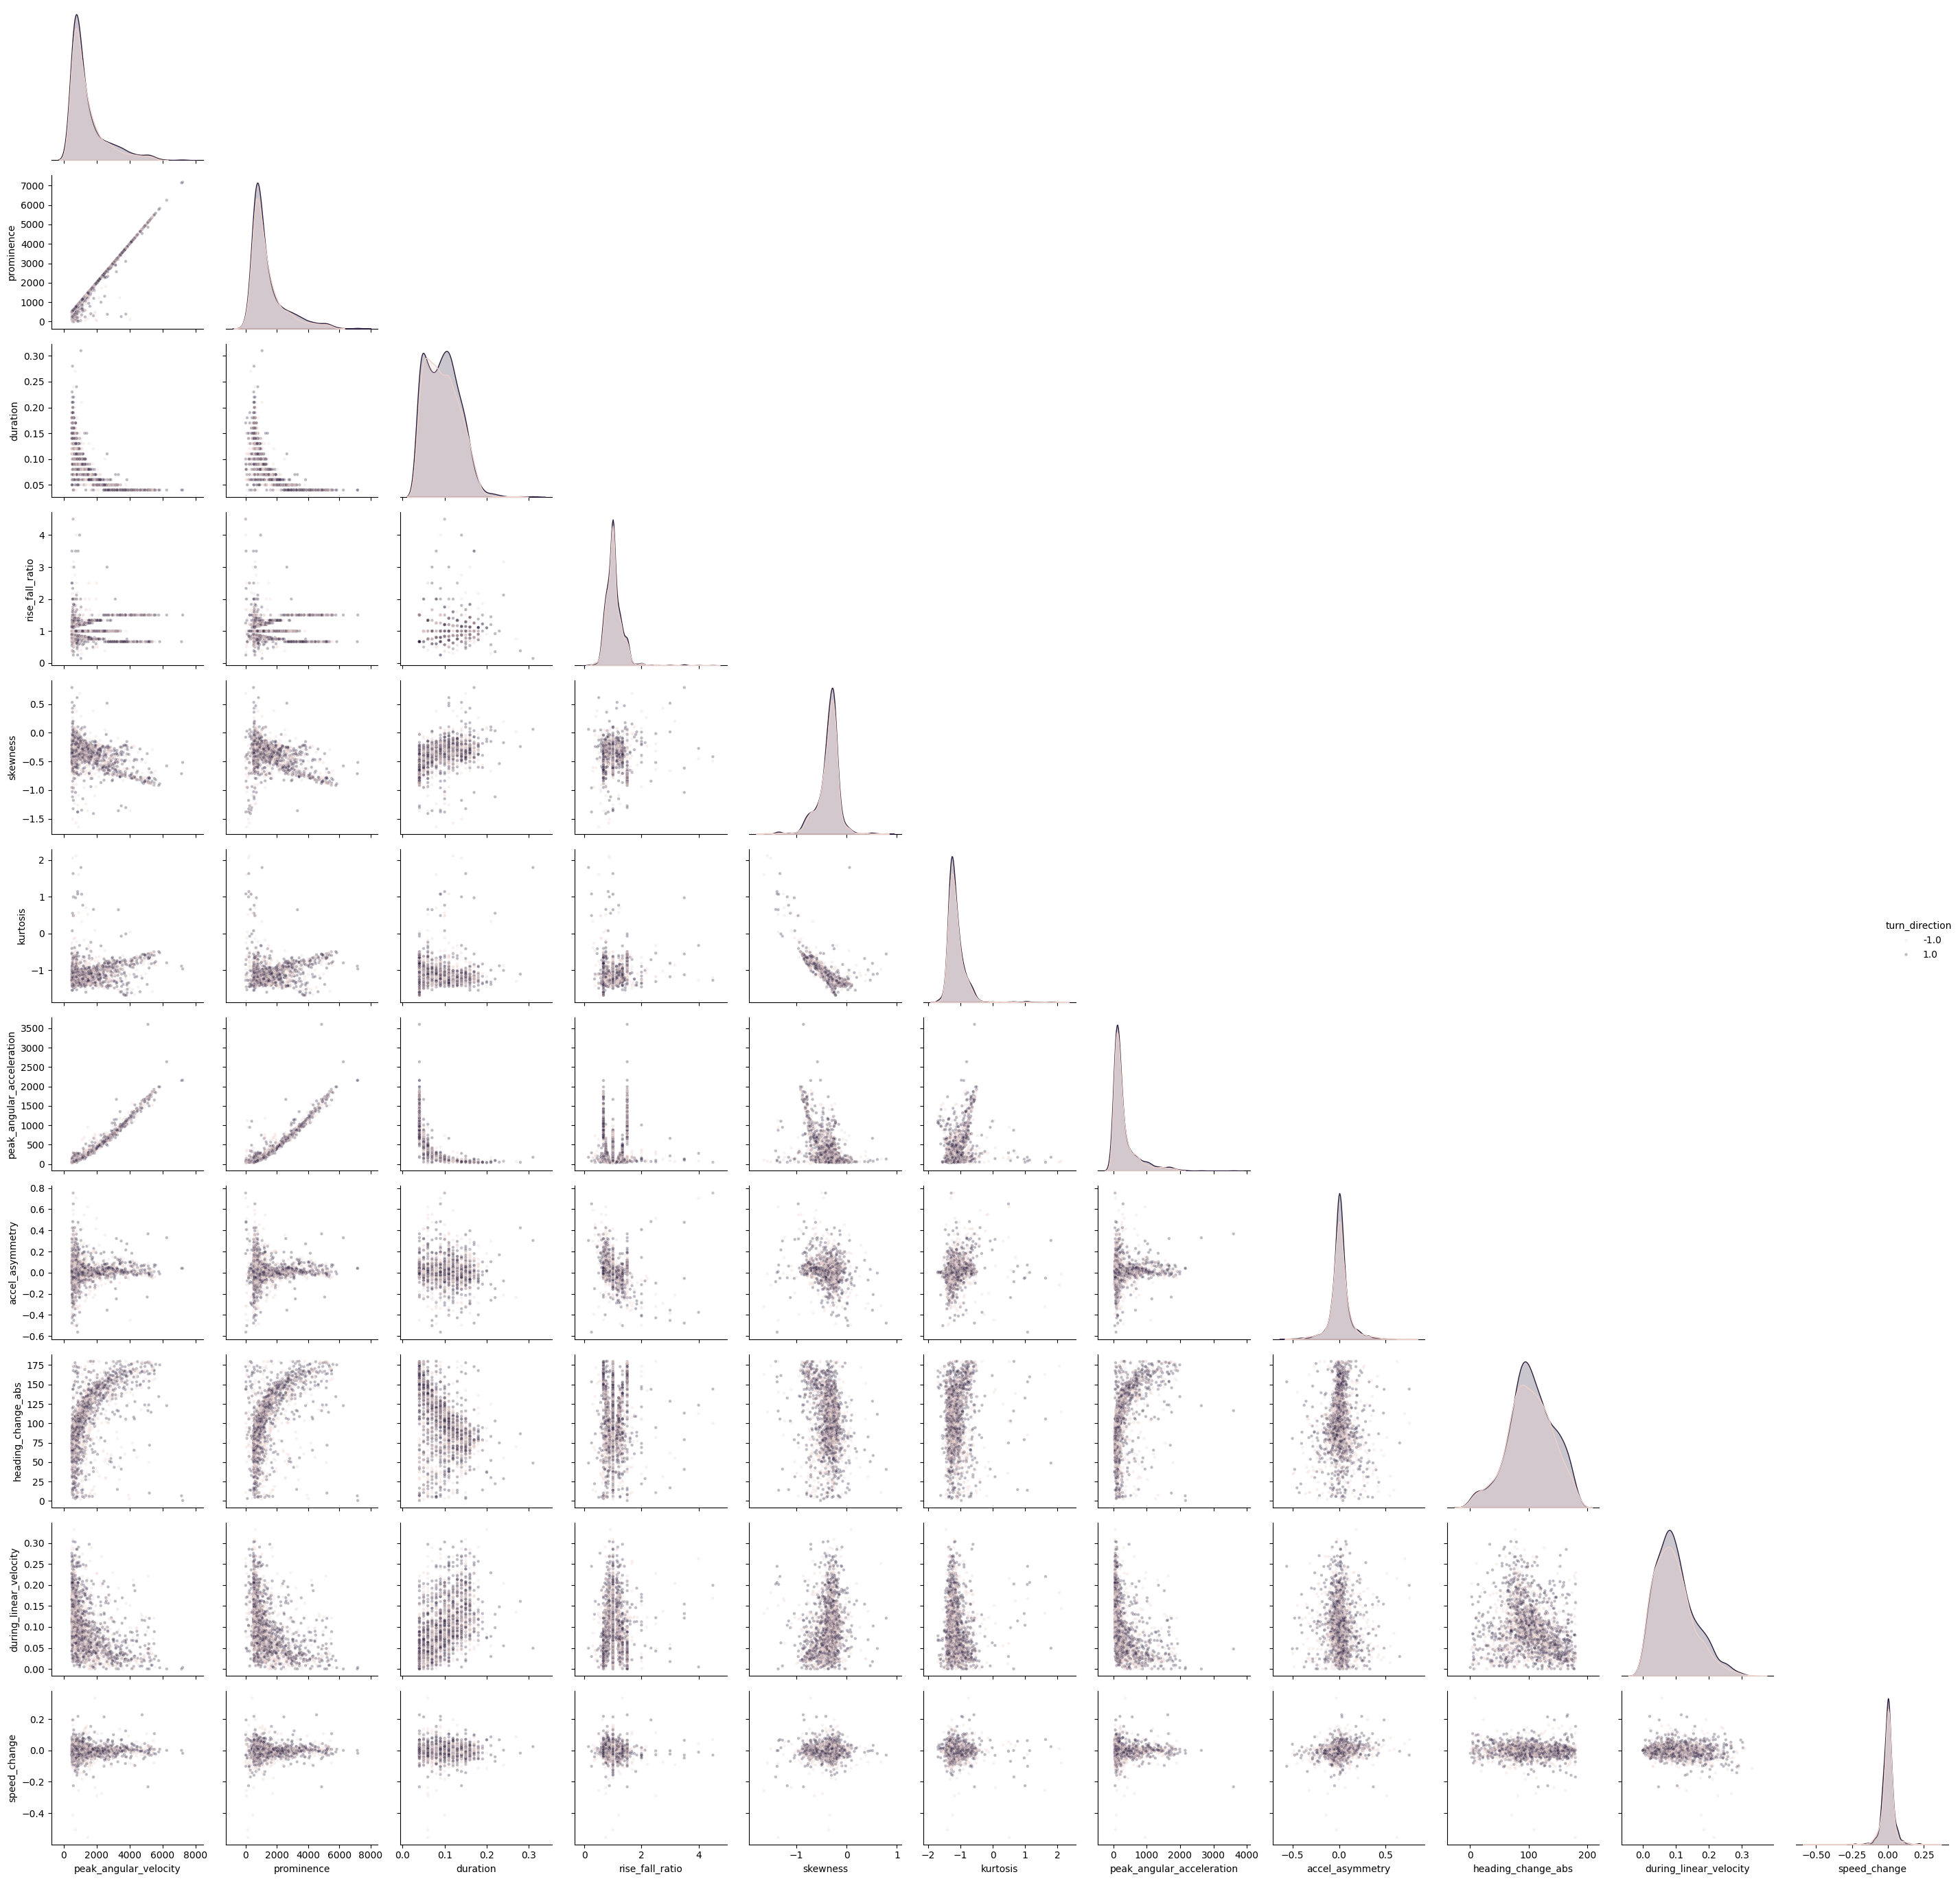

In [257]:
clustering_features = [
    # === INTENSITY ===
    "peak_angular_velocity",     # How fast the turn
    "prominence",                 # How distinct from baseline
    
    # === TEMPORAL STRUCTURE ===
    "duration",                   # How long it lasts
    "rise_fall_ratio",           # Symmetry (ballistic vs gradual)
    
    # === SHAPE ===
    "skewness",                   # Profile asymmetry
    "kurtosis",                   # Peakiness vs broad
    
    # === DYNAMICS ===
    "peak_angular_acceleration", # Explosiveness
    "accel_asymmetry",           # Attack vs decay
    
    # === FUNCTIONAL OUTCOME ===
    "heading_change_abs",            # Actual reorientation (the NEW one!)
    
    # === BEHAVIORAL CONTEXT ===
    "during_linear_velocity",    # Speed during turn (or peak_linear_velocity)
    "speed_change",              # Speed strategy
]

saccade_features["heading_change_abs"] = np.abs(saccade_features["heading_change"])

sns.pairplot(
    saccade_features[clustering_features + ["turn_direction"]],
    hue="turn_direction",
    diag_kind="kde",
    plot_kws={"alpha": 0.3, "s": 10},
    corner=True,
)
plt.tight_layout()
plt.savefig("saccade_feature_pairs.png", dpi=90)  # Also increased DPI for clarity


In [ ]:
processed_data = [
    run_pipeline(group)
    for group in tqdm(filtered_groups, desc="Processing trajectories")
]

Processing trajectories: 100%|██████████| 416/416 [00:07<00:00, 56.96it/s]


In [231]:
processed_data_df = pd.concat(processed_data, ignore_index=True)

/tmp/ipykernel_477147/391217220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saccade_data["angular_velocity_abs"] = saccade_data["angular_velocity"].abs()


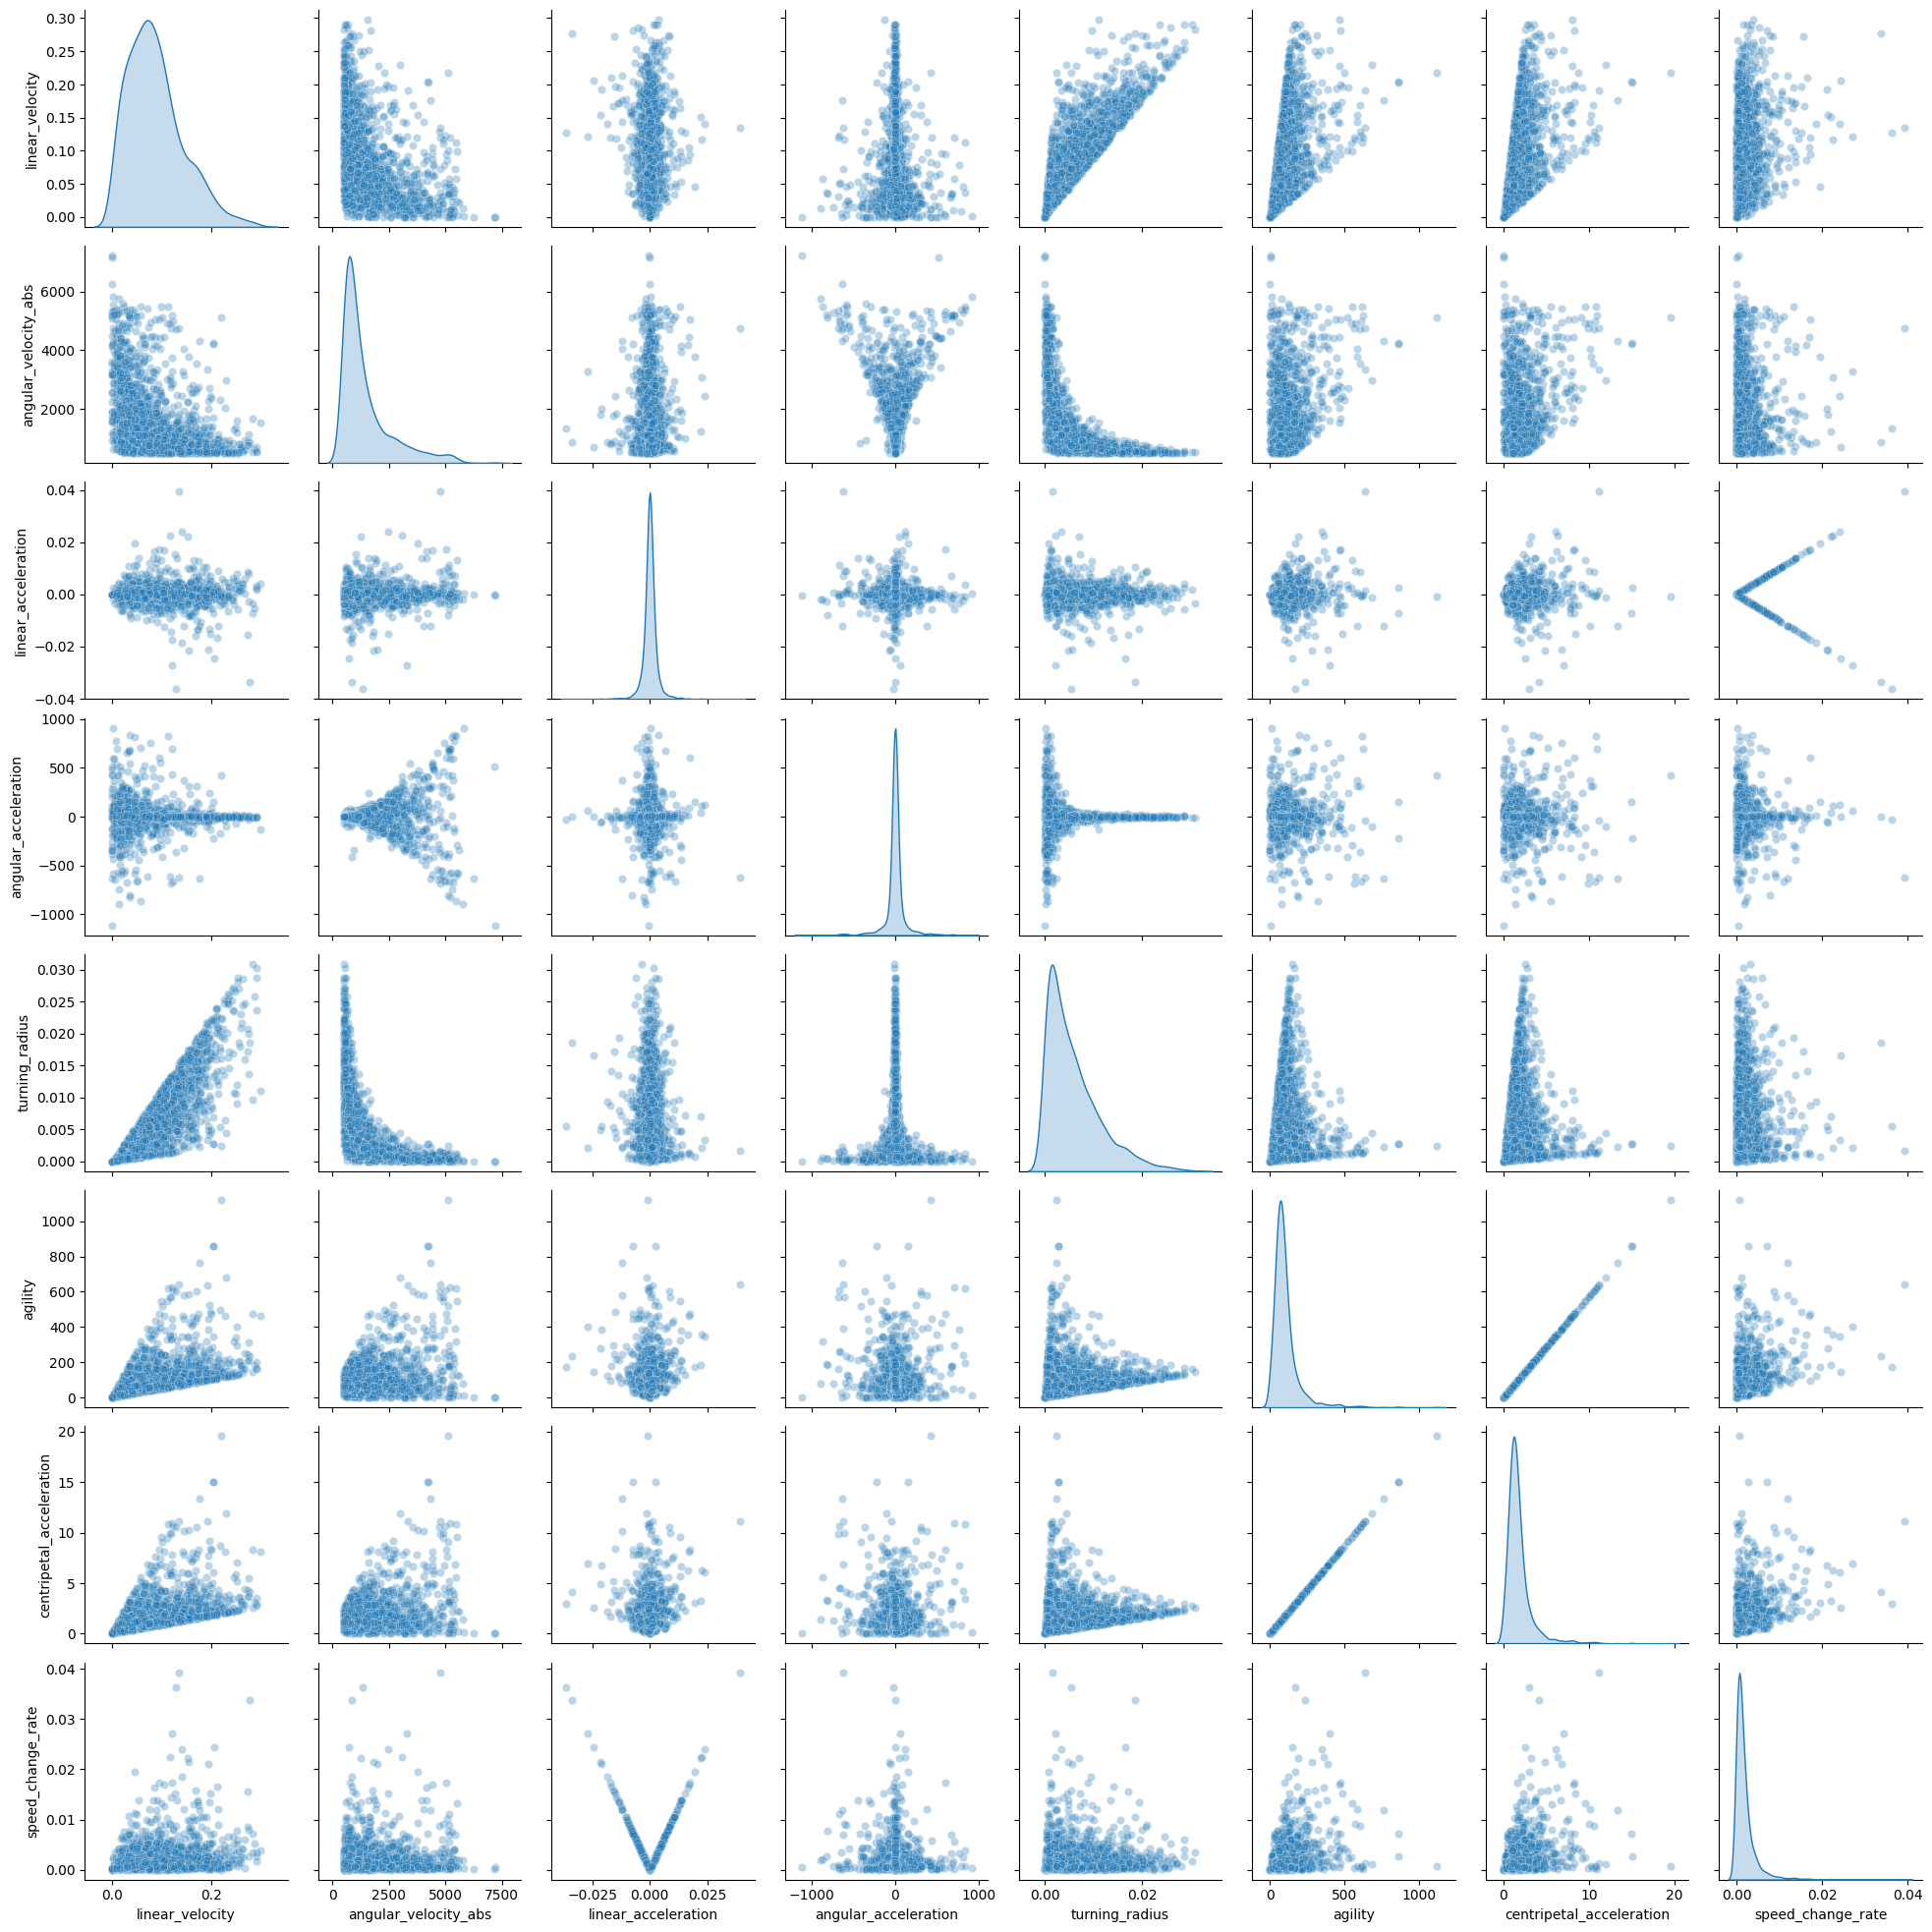

In [ ]:
import seaborn as sns

kinematic_vars = [
    "linear_velocity",
    "angular_velocity_abs",
    "linear_acceleration",
    "angular_acceleration",
    "turning_radius",
    "agility",
    "centripetal_acceleration",
    "speed_change_rate",
]

saccade_data = processed_data_df[processed_data_df["saccade"] == 1]
saccade_data["angular_velocity_abs"] = saccade_data["angular_velocity"].abs()
sns.pairplot(saccade_data[kinematic_vars], diag_kind="kde", plot_kws={"alpha": 0.3})

In [ ]:
def extract_saccade_bouts(
    df: pd.DataFrame,
    saccade_col: str = "saccade",
    window_pre: int = 10,
    window_post: int = 10,
) -> pd.DataFrame:
    """Extract temporal windows around each saccade peak."""
    saccade_peaks = df[df[saccade_col] == 1].index.tolist()

    bout_features = []
    for peak_idx in saccade_peaks:
        start = max(0, peak_idx - window_pre)
        end = min(len(df), peak_idx + window_post)
        bout = df.iloc[start:end]

        # Extract features that describe the ENTIRE maneuver
        features = {
            "peak_angular_vel": df.loc[peak_idx, "angular_velocity"],
            "pre_linear_vel": bout.iloc[:window_pre]["linear_velocity"].mean(),
            "post_linear_vel": bout.iloc[-window_post:]["linear_velocity"].mean(),
            "total_heading_change": bout["angular_velocity"].sum()
            * SAMPLING_RATE,  # Total angle turned
            "duration": len(bout) * SAMPLING_RATE,
            "peak_acceleration": bout["angular_acceleration"].abs().max(),
            "acceleration_asymmetry": bout[
                "angular_acceleration"
            ].skew(),  # Sharp onset vs gradual?
            "saccade_direction": np.sign(
                df.loc[peak_idx, "angular_velocity"]
            ),  # Left vs right
        }
        bout_features.append(features)

    return pd.DataFrame(bout_features)


saccade_bouts = extract_saccade_bouts(processed_data_df)

Text(0.5, 1.0, 'UMAP')

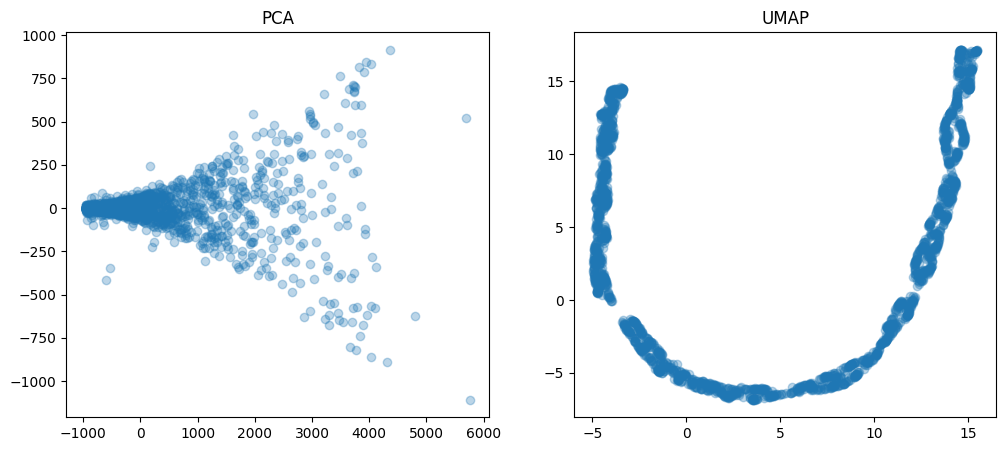

In [ ]:
from sklearn.decomposition import PCA
from umap import UMAP

features_for_clustering = [
    "linear_velocity",
    "angular_velocity_abs",
    "linear_acceleration",
    "angular_acceleration",
    "turning_radius",  # Only include relatively independent variables
]

X = saccade_data[features_for_clustering].dropna()

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# UMAP (better for nonlinear structure)
reducer = UMAP(n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
ax1.set_title("PCA")
ax2.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.3)
ax2.set_title("UMAP")

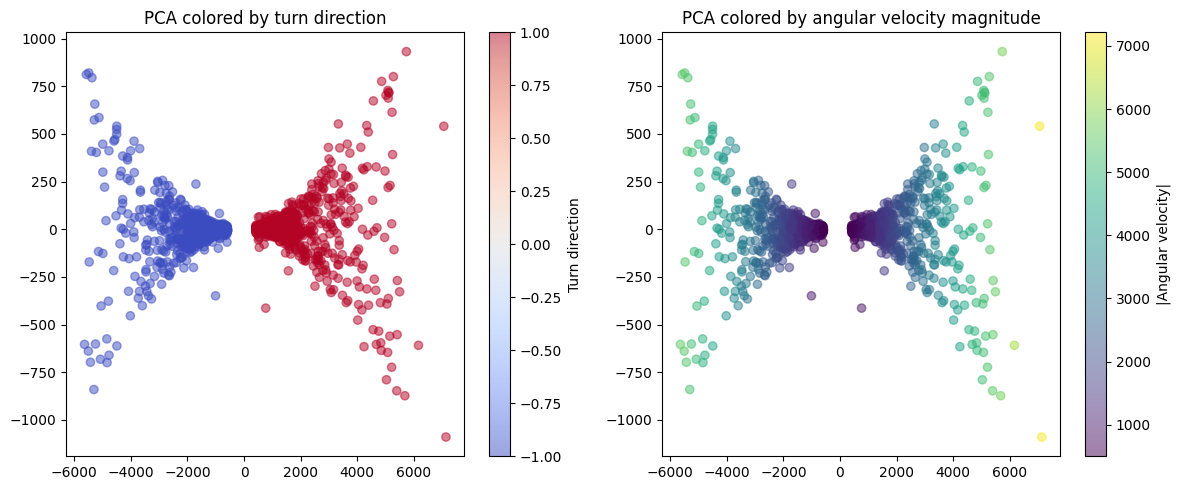

In [ ]:
# Color by turn direction
turn_direction = np.sign(saccade_data["angular_velocity"].values)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=turn_direction, cmap="coolwarm", alpha=0.5)
plt.title("PCA colored by turn direction")
plt.colorbar(label="Turn direction")

plt.subplot(122)
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=np.abs(saccade_data["angular_velocity"].values),
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA colored by angular velocity magnitude")
plt.colorbar(label="|Angular velocity|")
plt.tight_layout()